# **Feature Engineering**

In [1]:
# Importing necessary libraries:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint

In [2]:
# Reading the training dataset into a pandas dataframe:
data_train = pd.read_csv('mushroom_train.csv')
# Calculating the correlation of the numerical features:
corr_matrix = data_train.corr()
print("The correlation between the numerical columns of the features-\n", corr_matrix)

The correlation between the numerical columns of the features-
               cap-diameter  stem-height  stem-width
cap-diameter      1.000000     0.423171    0.695804
stem-height       0.423171     1.000000    0.436069
stem-width        0.695804     0.436069    1.000000


In [3]:
# Separating the categorical data:
categorical_col = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season','class']
categorical_data_train = data_train[categorical_col]
encoded_data_train = pd.get_dummies(categorical_data_train, prefix = categorical_col, prefix_sep = '_') # One-hot encoding.

**Standardizing the numerical features**

In [4]:
numerical_col_train = data_train[['cap-diameter', 'stem-height', 'stem-width']] # Separating the numerical columns.
scaler = StandardScaler()
numerical_col_scaled_train = scaler.fit_transform(numerical_col_train)
numerical_data_train = pd.DataFrame(numerical_col_scaled_train, columns = numerical_col_train.columns)

In [5]:
# Concatenating the columns (standardized numerical columns and the one-hot encoded categorical data) into one dataframe:
final_data_train = pd.concat([numerical_data_train, encoded_data_train], axis = 1)
df_temp = pd.DataFrame({'zeros': [0] * 42748})
df_temp.loc[final_data_train.iloc[:, -2] == 1, 'zeros'] = 0
df_temp.loc[final_data_train.iloc[:, -1] == 1, 'zeros'] = 1
final_data_train = final_data_train.drop(final_data_train.columns[-2:], axis = 1)
final_data_train_watch = pd.concat([final_data_train, df_temp], axis = 1)
final_data_train_watch = final_data_train_watch.rename(columns = {'<old_column_name>': 'label'})
new_data_train_watch = final_data_train_watch.reset_index()

# **Pearson's correlation**

In [6]:
# Separating the numerical columns:
cols_of_interest = ['stem-width', 'stem-height', 'cap-diameter']
corr_matrix = final_data_train.corr(method = 'pearson') # Computing the correlation matrix.
corr_filtered = corr_matrix[(corr_matrix.index.isin(cols_of_interest)) | (corr_matrix.columns.isin(cols_of_interest))] # Filtering out the correlation matrix to only include with 'stem-width', 'stem-height', or 'cap-diameter' columns.
# Creating a copy of the filtered correlation matrix to sort and to remove self-correlations:
corr_sorted = corr_filtered.abs().unstack().sort_values(ascending = False).reset_index()
corr_sorted = corr_sorted[corr_sorted['level_0'] != corr_sorted['level_1']]
corr_sorted.columns = ['Feature-1', 'Feature-2', 'Correlation coefficient']
corr_sorted_filtered = corr_sorted[(corr_sorted['Feature-1'].isin(cols_of_interest)) | (corr_sorted['Feature-2'].isin(cols_of_interest))]

# Printing the top 10 positively and top 10 negatively correlated features:
print("Top 10 positive correlations:\n", corr_sorted_filtered.head(10))
print("\nTop 10 negative correlations:\n", corr_sorted_filtered.tail(10)[::-1])

Top 10 positive correlations:
             Feature-1     Feature-2  Correlation coefficient
3        cap-diameter    stem-width                 0.695804
4          stem-width  cap-diameter                 0.695804
5         stem-height    stem-width                 0.436069
6          stem-width   stem-height                 0.436069
7         stem-height  cap-diameter                 0.423171
8        cap-diameter   stem-height                 0.423171
9         ring-type_m   stem-height                 0.406376
10  gill-attachment_p    stem-width                 0.400621
11  gill-attachment_p  cap-diameter                 0.353896
12        ring-type_f   stem-height                 0.332793

Top 10 negative correlations:
           Feature-1     Feature-2  Correlation coefficient
275    gill-color_o    stem-width                 0.000822
274     cap-color_e  cap-diameter                 0.000841
273    stem-color_u   stem-height                 0.000941
272     ring-type_l    stem-wi

In [7]:
new_data_train_watch = pd.concat([new_data_train_watch, df_temp], axis = 1)
# Reset the index of the DataFrame and creating a new column 'index':
new_data_train_watch.reset_index(inplace = True)
new_data_train_watch.rename(columns = {'index': 'index_column'}, inplace = True)

**Adding new features**

In [8]:
selected_rows_shape_m = new_data_train_watch[new_data_train_watch['ring-type_m'] == 1] # Selecting the rows where 'ring-type_m' is 1.
selected_data_m = pd.DataFrame(selected_rows_shape_m, columns = new_data_train_watch.columns) # Create a new dataframe with the selected rows.
selected_data_m = new_data_train_watch.loc[new_data_train_watch['ring-type_m'] == 1].copy()
# Computing the minimum, maximum and average of the corresponding numerical columns:
stem_width_min = selected_data_m['stem-width'].min()
stem_width_max = selected_data_m['stem-width'].max()
stem_width_mean = selected_data_m['stem-width'].mean()
selected_data_m['stem_width_ring_type_m_min'] = stem_width_min
selected_data_m['stem_width_ring_type_m_max'] = stem_width_max
selected_data_m['stem_width_ring_type_m_mean'] = stem_width_mean

selected_data_m = selected_data_m.rename(columns = {'zeros': 'label1'})
selected_data_m = selected_data_m.loc[:, ~selected_data_m.columns.duplicated()] # Deleting the duplicate <'label'> column.
selected_data_m = selected_data_m[['index_column', 'stem_width_ring_type_m_min', 'stem_width_ring_type_m_max', 'stem_width_ring_type_m_mean', 'label1']]

In [9]:
selected_rows_shape_p = new_data_train_watch[new_data_train_watch['gill-attachment_p'] == 1] 
selected_data = pd.DataFrame(selected_rows_shape_p, columns = new_data_train_watch.columns)
selected_data_p = new_data_train_watch.loc[new_data_train_watch['gill-attachment_p'] == 1].copy()

stem_width_min = selected_data_p['stem-width'].min()
stem_width_max = selected_data_p['stem-width'].max()
stem_width_mean = selected_data_p['stem-width'].mean()
selected_data_p['stem_width_gill_attachment_p_min'] = stem_width_min
selected_data_p['stem_width_gill_attachment_p_max'] = stem_width_max
selected_data_p['stem_width_gill_attachment_p_mean'] = stem_width_mean

selected_data_p = selected_data_p.rename(columns = {'zeros': 'label2'})
selected_data_p = selected_data_p.loc[:, ~selected_data_p.columns.duplicated()]
selected_data_p = selected_data_p[['index_column', 'stem_width_gill_attachment_p_min', 'stem_width_gill_attachment_p_max', 'stem_width_gill_attachment_p_mean', 'label2']]

In [10]:
selected_rows_shape_f = new_data_train_watch[new_data_train_watch['ring-type_f'] == 1]
selected_data = pd.DataFrame(selected_rows_shape_f, columns = new_data_train_watch.columns)
selected_data_f = new_data_train_watch.loc[new_data_train_watch['ring-type_f'] == 1].copy()

stem_height_min = selected_data_f['stem-height'].min()
stem_height_max = selected_data_f['stem-height'].max()
stem_height_mean = selected_data_f['stem-height'].mean()
selected_data_f['stem_height_ring_type_f_min'] = stem_height_min
selected_data_f['stem_height_ring_type_f_max'] = stem_height_max
selected_data_f['stem_height_ring_type_f_mean'] = stem_height_mean

selected_data_f = selected_data_f.rename(columns = {'zeros': 'label3'})
selected_data_f = selected_data_f.loc[:, ~selected_data_f.columns.duplicated()]
selected_data_f = selected_data_f[['index_column', 'stem_height_ring_type_f_min', 'stem_height_ring_type_f_max', 'stem_height_ring_type_f_mean', 'label3']]

In [11]:
selected_rows_shape_o = new_data_train_watch[new_data_train_watch['gill-color_o'] == 1]
selected_data = pd.DataFrame(selected_rows_shape_o, columns = new_data_train_watch.columns)
selected_data_o = new_data_train_watch.loc[new_data_train_watch['gill-color_o'] == 1].copy()

stem_width_min = selected_data_o['stem-width'].min()
stem_width_max = selected_data_o['stem-width'].max()
stem_width_mean = selected_data_o['stem-width'].mean()
selected_data_o['stem_width_gill_color_o_min'] = stem_width_min
selected_data_o['stem_width_gill_color_o_max'] = stem_width_max
selected_data_o['stem_width_gill_color_o_mean'] = stem_width_mean

selected_data_o = selected_data_o.rename(columns = {'zeros': 'label4'})
selected_data_o = selected_data_o.loc[:, ~selected_data_o.columns.duplicated()]
selected_data_o = selected_data_o[['index_column', 'stem_width_gill_color_o_min', 'stem_width_gill_color_o_max', 'stem_width_gill_color_o_mean', 'label4']]

In [12]:
selected_rows_shape_e = new_data_train_watch[new_data_train_watch['cap-color_e'] == 1]
selected_data = pd.DataFrame(selected_rows_shape_e, columns = new_data_train_watch.columns)
selected_data_e = new_data_train_watch.loc[new_data_train_watch['cap-color_e'] == 1].copy()

cap_diameter_min = selected_data_e['cap-diameter'].min()
cap_diameter_max = selected_data_e['cap-diameter'].max()
cap_diameter_mean = selected_data_e['cap-diameter'].mean()
selected_data_e['cap_diameter_cap_color_e_min'] = cap_diameter_min
selected_data_e['cap_diameter_cap_color_e_max'] = cap_diameter_max
selected_data_e['cap_diameter_cap_color_e_mean'] = cap_diameter_mean

selected_data_e = selected_data_e.rename(columns = {'zeros': 'label5'})
selected_data_e = selected_data_e.loc[:, ~selected_data_e.columns.duplicated()]
selected_data_e = selected_data_e[['index_column', 'cap_diameter_cap_color_e_min', 'cap_diameter_cap_color_e_max', 'cap_diameter_cap_color_e_mean', 'label5']]

In [13]:
selected_rows_shape_p_only = new_data_train_watch[new_data_train_watch['cap-shape_p'] == 1]
selected_data = pd.DataFrame(selected_rows_shape_p_only, columns = new_data_train_watch.columns)
selected_data_p_only = new_data_train_watch.loc[new_data_train_watch['cap-shape_p'] == 1].copy()

cap_diameter_min = selected_data_p_only['cap-diameter'].min()
cap_diameter_max = selected_data_p_only['cap-diameter'].max()
cap_diameter_mean = selected_data_p_only['cap-diameter'].mean()
selected_data_p_only['cap_diameter_p_min'] = cap_diameter_min
selected_data_p_only['cap_diameter_p_max'] = cap_diameter_max
selected_data_p_only['cap_diameter_p_mean'] = cap_diameter_mean

selected_data_p_only = selected_data_p_only.rename(columns = {'zeros': 'label6'})
selected_data_p_only = selected_data_p_only.loc[:, ~selected_data_p_only.columns.duplicated()]
selected_data_p_only = selected_data_p_only[['index_column', 'cap_diameter_p_min', 'cap_diameter_p_max', 'cap_diameter_p_mean', 'label6']]

In [14]:
dataframes = [new_data_train_watch, selected_data_m, selected_data_p, selected_data_f, selected_data_o, selected_data_e, selected_data_p_only]
concatenated_df = pd.concat(dataframes, axis = 1, join = 'outer') # Concatenating all the created dataframes based on a common index.
concatenated_df['common_index'] = concatenated_df.index
concatenated_df.fillna(0, inplace = True) # Replacing any Not-a-Number values with zeroes.
concatenated_df.set_index('common_index', inplace = True)
concatenated_df = concatenated_df.drop('index_column', axis = 1)
concatenated_df = concatenated_df.drop('level_0', axis = 1) # Dropping the common index column.
print("DataFrame with the all augmented features:\n", concatenated_df.columns)

DataFrame with the all augmented features:
 Index(['cap-diameter', 'stem-height', 'stem-width', 'cap-shape_b',
       'cap-shape_c', 'cap-shape_f', 'cap-shape_o', 'cap-shape_p',
       'cap-shape_s', 'cap-shape_x',
       ...
       'stem_width_gill_color_o_mean', 'label4',
       'cap_diameter_cap_color_e_min', 'cap_diameter_cap_color_e_max',
       'cap_diameter_cap_color_e_mean', 'label5', 'cap_diameter_p_min',
       'cap_diameter_p_max', 'cap_diameter_p_mean', 'label6'],
      dtype='object', length=118)


In [15]:
# Defining a function to check if any of the label columns has '1':
def has_label(row):
    label_cols = ['label1', 'label2', 'label3', 'label4', 'label5', 'label6']
    
    for col in label_cols:
        
        if row[col] == 1:
            return 1
    
    return 0

In [16]:
concatenated_df['label'] = concatenated_df.apply(has_label, axis = 1)
concatenated_df = concatenated_df.drop(['label1', 'label2', 'label3', 'label4','label5','label6'], axis = 1)
concatenated_df = concatenated_df.drop(['zeros'], axis = 1)
concatenated_df_train = concatenated_df # Final training dataframe.
label_column_train = concatenated_df_train.iloc[:, -1] # Labels of the final training dataframe. 
concatenated_df_train.describe()

,cap-diameter,stem-height,stem-width,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_o,cap-shape_p,cap-shape_s,cap-shape_x,...,stem_width_gill_color_o_min,stem_width_gill_color_o_max,stem_width_gill_color_o_mean,cap_diameter_cap_color_e_min,cap_diameter_cap_color_e_max,cap_diameter_cap_color_e_mean,cap_diameter_p_min,cap_diameter_p_max,cap_diameter_p_mean,label
count,4.274800e+04,4.274800e+04,4.274800e+04,42748.000000,42748.000000,42748.000000,42748.000000,42748.000000,42748.000000,42748.000000,...,42748.000000,42748.000000,42748.000000,42748.000000,42748.000000,42748.000000,42748.000000,42748.000000,42748.000000,42748.000000
mean,-2.940579e-16,1.759299e-17,1.877183e-16,0.094578,0.030130,0.217297,0.056541,0.042669,0.118813,0.439974,...,-0.054011,0.127143,-0.000175,-0.076948,0.266904,-0.000207,-0.050550,0.176691,0.019000,0.479648
std,1.000012e+00,1.000012e+00,1.000012e+00,0.292634,0.170947,0.412411,0.230965,0.202111,0.323572,0.496390,...,0.241211,0.567820,0.000783,0.291710,1.011835,0.000786,0.239444,0.836945,0.089997,0.499591
min,-1.213451e+00,-1.954469e+00,-1.211193e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-1.131231,0.000000,-0.003670,-1.182799,0.000000,-0.003187,-1.184715,0.000000,0.000000,0.000000
25%,-6.195751e-01,-5.769166e-01,-6.934393e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-1.626738e-01,-1.850268e-01,-1.916780e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.478678e-01,3.463996e-01,4.420205e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.065640e+01,8.115913e+00,9.174866e+00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,2.662964,0.000000,0.000000,4.102695,0.000000,0.000000,4.141010,0.445286,1.000000


# **Principal Component Analysis**

In [17]:
pca = PCA(n_components = 11) # Defining the number of features to pass to the PCA function.
pcs = pca.fit_transform(concatenated_df_train)
top_feature_names = []

for comps in range(pca.n_components_):
    component_loadings = abs(pca.components_[comps])
    sorted_indices = component_loadings.argsort()[::-1]
    top_feature_indices = sorted_indices[:pca.n_components]
    top_feature_names.append(concatenated_df_train.columns[top_feature_indices].tolist())

all_top_feature_names = [name for sublist in top_feature_names for name in sublist] # Concatenating the lists of top feature names into a single list.
feature_counts = pd.Series(all_top_feature_names).value_counts().sort_values(ascending = False) # Counting the frequency of each feature and sorting in descending order.
top_features = feature_counts.index[:pca.n_components].tolist() # Extracting the most frequent features.
print("The optimal features determined by PCA-\n", top_features)

The optimal features determined by PCA-
 ['stem-width', 'stem-height', 'cap-diameter', 'cap-color_n', 'cap_diameter_p_max', 'cap-shape_x', 'gill-attachment_a', 'season_a', 'stem-color_w', 'stem_height_ring_type_f_max', 'gill-color_w']


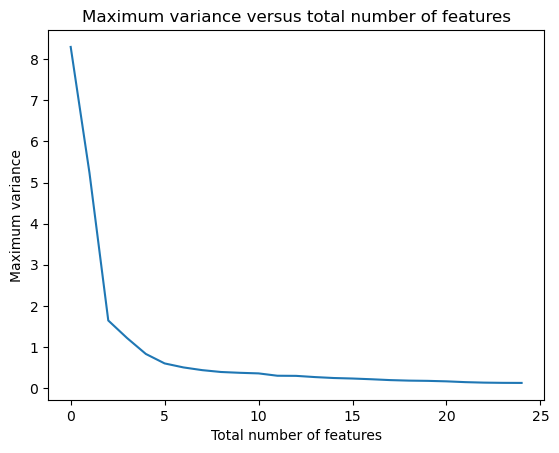

In [18]:
pca = PCA(n_components = 25)
pca.fit(concatenated_df_train)
variances = pca.explained_variance_


plt.plot(variances)
plt.xlabel("Total number of features")
plt.ylabel("Maximum variance")
plt.title("Maximum variance versus total number of features")
plt.show()

In [19]:
# Accessing the indices of the columns that correspond to the top features and creating a new dataframe of only top features:
top_feature_indices = [concatenated_df_train.columns.get_loc(feature) for feature in top_features[:pca.n_components]]
top_features_data_train = concatenated_df_train.iloc[:, top_feature_indices]
print(top_features_data_train)

              stem-width  stem-height  cap-diameter  cap-color_n  \
common_index                                                       
0              -0.590488    -0.161276     -0.332216            0   
1              -0.856362    -0.274093     -0.742182            0   
2               1.316604     0.132642      0.905345            0   
3               0.149160    -0.636294      0.393845            0   
4               0.631930     0.542345      0.160126            1   
...                  ...          ...           ...          ...   
42743          -0.860360    -0.481913     -0.657890            0   
42744          -0.099722    -0.585823      0.420665            0   
42745           1.423554    -0.247373      7.495450            0   
42746           1.225648     0.287022      0.803811            1   
42747          -0.840369    -0.909429     -0.824558            0   

              cap_diameter_p_max  cap-shape_x  gill-attachment_a  season_a  \
common_index                         

**Standardizing the testing dataset**

In [20]:
data_test = pd.read_csv('mushroom_test.csv')
categorical_col = ['cap-shape', 'cap-surface', 'cap-color', 'does-bruise-or-bleed', 'gill-attachment', 'gill-spacing', 'gill-color', 'stem-color', 'has-ring', 'ring-type', 'habitat', 'season','class']
categorical_data_test = data_test[categorical_col]
encoded_data_test = pd.get_dummies(categorical_data_test, prefix = categorical_col, prefix_sep = '_') # One-hot encoding the categorical values.
numerical_col_test = data_test[['cap-diameter', 'stem-height', 'stem-width']]
scaler = StandardScaler()
numerical_col_scaled_test = scaler.fit_transform(numerical_col_test)
numerical_data_test = pd.DataFrame(numerical_col_scaled_test, columns = numerical_col_test.columns)
final_data_test = pd.concat([numerical_data_test, encoded_data_test], axis = 1)

In [21]:
df_temp = pd.DataFrame({'zeros': [0] * (final_data_test.shape[0])})
df_temp.loc[final_data_test.iloc[:,-2] == 1, 'zeros'] = 0
df_temp.loc[final_data_test.iloc[:,-1] == 1, 'zeros'] = 1
final_data_test = final_data_test.drop(final_data_test.columns[-2:], axis = 1)
final_data_test_watch = pd.concat([final_data_test, df_temp], axis = 1)
final_data_test_watch = final_data_test_watch.rename(columns={'<old_column_name>': 'label'})
new_data_test_watch= final_data_test.reset_index()
new_data_test_watch.rename(columns = {'index': 'index_column'}, inplace = True)
new_data_test_watch = pd.concat([new_data_test_watch, df_temp], axis = 1)
new_data_test_watch.reset_index(inplace = True)
new_data_test_watch.rename(columns = {'index': 'index_column'}, inplace = True)

**Adding new features to the testing dataset**

In [22]:
selected_rows_shape_m_test = new_data_test_watch[new_data_test_watch['ring-type_m'] == 1]
selected_data_m_test = pd.DataFrame(selected_rows_shape_m_test, columns = new_data_test_watch.columns)
selected_data_m_test = new_data_test_watch.loc[new_data_test_watch['ring-type_m'] == 1].copy()

stem_width_min_test = selected_data_m_test['stem-width'].min()
stem_width_max_test = selected_data_m_test['stem-width'].max()
stem_width_mean_test = selected_data_m_test['stem-width'].mean()
selected_data_m_test['stem_width_ring_type_m_min'] = stem_width_min_test
selected_data_m_test['stem_width_ring_type_m_max'] = stem_width_max_test
selected_data_m_test['stem_width_ring_type_m_mean'] = stem_width_mean_test

selected_data_m_test = selected_data_m_test.rename(columns = {'zeros': 'label1'})
selected_data_m_test = selected_data_m_test.loc[:, ~selected_data_m_test.columns.duplicated()]
selected_data_m_test = selected_data_m_test[['index_column', 'stem_width_ring_type_m_min', 'stem_width_ring_type_m_max', 'stem_width_ring_type_m_mean', 'label1']]

In [23]:
selected_rows_shape_p_test = new_data_test_watch[new_data_test_watch['gill-attachment_p'] == 1]
selected_data_test = pd.DataFrame(selected_rows_shape_p_test, columns = new_data_test_watch.columns)
selected_data_p_test = new_data_test_watch.loc[new_data_test_watch['gill-attachment_p'] == 1].copy()

stem_width_min_test = selected_data_p_test['stem-width'].min()
stem_width_max_test = selected_data_p_test['stem-width'].max()
stem_width_mean_test = selected_data_p_test['stem-width'].mean()
selected_data_p_test['stem_width_gill_attachment_p_min'] = stem_width_min
selected_data_p_test['stem_width_gill_attachment_p_max'] = stem_width_max
selected_data_p_test['stem_width_gill_attachment_p_mean'] = stem_width_mean

selected_data_p_test = selected_data_p_test.rename(columns = {'zeros': 'label2'})
selected_data_p_test = selected_data_p_test.loc[:, ~selected_data_p_test.columns.duplicated()]
selected_data_p_test = selected_data_p_test[['index_column', 'stem_width_gill_attachment_p_min', 'stem_width_gill_attachment_p_max', 'stem_width_gill_attachment_p_mean', 'label2']]

In [24]:
selected_rows_shape_f_test = new_data_test_watch[new_data_test_watch['ring-type_f'] == 1]
selected_data_test = pd.DataFrame(selected_rows_shape_f_test, columns = new_data_test_watch.columns)
selected_data_f_test = new_data_test_watch.loc[new_data_test_watch['ring-type_f'] == 1].copy()

stem_height_min_test = selected_data_f_test['stem-height'].min()
stem_height_max_test = selected_data_f_test['stem-height'].max()
stem_height_mean_test = selected_data_f_test['stem-height'].mean()
selected_data_f_test['stem_height_ring_type_f_min'] = stem_height_min_test
selected_data_f_test['stem_height_ring_type_f_max'] = stem_height_max_test
selected_data_f_test['stem_height_ring_type_f_mean'] = stem_height_mean_test

selected_data_f_test = selected_data_f_test.rename(columns = {'zeros': 'label3'})
selected_data_f_test = selected_data_f_test.loc[:, ~selected_data_f_test.columns.duplicated()]
selected_data_f_test = selected_data_f_test[['index_column', 'stem_height_ring_type_f_min', 'stem_height_ring_type_f_max', 'stem_height_ring_type_f_mean', 'label3']]

In [25]:
selected_rows_shape_o_test = new_data_test_watch[new_data_test_watch['gill-color_o'] == 1]
selected_data_test = pd.DataFrame(selected_rows_shape_o_test, columns = new_data_test_watch.columns)
selected_data_o_test = new_data_test_watch.loc[new_data_test_watch['gill-color_o'] == 1].copy()

stem_width_min_test = selected_data_o_test['stem-width'].min()
stem_width_max_test = selected_data_o_test['stem-width'].max()
stem_width_mean_test = selected_data_o_test['stem-width'].mean()
selected_data_o_test['stem_width_gill_color_o_min'] = stem_width_min_test
selected_data_o_test['stem_width_gill_color_o_max'] = stem_width_max_test
selected_data_o_test['stem_width_gill_color_o_mean'] = stem_width_mean_test

selected_data_o_test = selected_data_o_test.rename(columns = {'zeros': 'label4'})
selected_data_o_test = selected_data_o_test.loc[:, ~selected_data_o_test.columns.duplicated()]
selected_data_o_test = selected_data_o_test[['index_column', 'stem_width_gill_color_o_min', 'stem_width_gill_color_o_max', 'stem_width_gill_color_o_mean', 'label4']]

In [26]:
selected_rows_shape_e_test = new_data_test_watch[new_data_test_watch['cap-color_e'] == 1]
selected_data_test = pd.DataFrame(selected_rows_shape_e_test, columns = new_data_test_watch.columns)
selected_data_e_test = new_data_test_watch.loc[new_data_test_watch['cap-color_e'] == 1].copy()

cap_diameter_min_test = selected_data_e_test['cap-diameter'].min()
cap_diameter_max_test = selected_data_e_test['cap-diameter'].max()
cap_diameter_mean_test = selected_data_e_test['cap-diameter'].mean()
selected_data_e_test['cap_diameter_cap_color_e_min'] = cap_diameter_min_test
selected_data_e_test['cap_diameter_cap_color_e_max'] = cap_diameter_max_test
selected_data_e_test['cap_diameter_cap_color_e_mean'] = cap_diameter_mean_test

selected_data_e_test = selected_data_e_test.rename(columns = {'zeros': 'label5'})
selected_data_e_test = selected_data_e_test.loc[:, ~selected_data_e_test.columns.duplicated()]
selected_data_e_test = selected_data_e_test[['index_column', 'cap_diameter_cap_color_e_min', 'cap_diameter_cap_color_e_max', 'cap_diameter_cap_color_e_mean', 'label5']]

In [27]:
selected_rows_shape_p_only_test = new_data_test_watch[new_data_test_watch['cap-shape_p'] == 1]
selected_data_test = pd.DataFrame(selected_rows_shape_p_only_test, columns = new_data_test_watch.columns)
selected_data_p_only_test = new_data_test_watch.loc[new_data_test_watch['cap-shape_p'] == 1].copy()

cap_diameter_min_test = selected_data_p_only_test['cap-diameter'].min()
cap_diameter_max_test = selected_data_p_only_test['cap-diameter'].max()
cap_diameter_mean_test = selected_data_p_only_test['cap-diameter'].mean()
selected_data_p_only_test['cap_diameter_p_min'] = cap_diameter_min_test
selected_data_p_only_test['cap_diameter_p_max'] = cap_diameter_max_test
selected_data_p_only_test['cap_diameter_p_mean'] = cap_diameter_mean_test

selected_data_p_only_test = selected_data_p_only_test.rename(columns = {'zeros': 'label6'})
selected_data_p_only_test = selected_data_p_only_test.loc[:, ~selected_data_p_only_test.columns.duplicated()]
selected_data_p_only_test = selected_data_p_only_test[['index_column', 'cap_diameter_p_min', 'cap_diameter_p_max', 'cap_diameter_p_mean', 'label6']]

In [28]:
dataframes_test = [new_data_test_watch, selected_data_m_test, selected_data_p_test, selected_data_f_test, selected_data_o_test, selected_data_e_test, selected_data_p_only_test]
concatenated_df_test = pd.concat(dataframes_test, axis = 1, join = 'outer')
concatenated_df_test = concatenated_df_test.drop('index_column', axis = 1)

In [29]:
concatenated_df_test['common_index'] = concatenated_df_test.index
concatenated_df_test.fillna(0, inplace = True)
concatenated_df_test.set_index('common_index', inplace = True)

def has_label(row):
    label_cols = ['label1', 'label2', 'label3', 'label4', 'label5', 'label6']
    
    for col in label_cols:
        
        if row[col] == 1:
            return 1
    return 0

concatenated_df_test['label'] = concatenated_df_test.apply(has_label, axis = 1)
concatenated_df_test = concatenated_df_test.drop(['label1', 'label2', 'label3', 'label4','label5','label6'], axis = 1)
concatenated_df_test = concatenated_df_test.drop(['zeros'], axis = 1)
last_column_test = concatenated_df_test.iloc[:, -1]
last_column_test = concatenated_df_test.iloc[:, -1].reset_index(drop = True)

In [30]:
# Extracting the indices of the columns in top PCA features training dataset to append to the testing dataset:
top_feature_indices_test = [concatenated_df_test.columns.get_loc(feature) for feature in top_features[:pca.n_components]]
top_features_data_test = concatenated_df_test.iloc[:, top_feature_indices_test]
print("The final testing dataset-\n", top_features_data_test)

The final testing dataset-
               stem-width  stem-height  cap-diameter  cap-color_n  \
common_index                                                       
0               0.989005     0.323775      1.335793            0   
1               2.393873    -0.055604      2.051180            1   
2              -1.066850    -0.378668     -0.983626            1   
3               1.422338    -0.420163      1.592885            1   
4               0.720893     5.036366      1.710253            0   
...                  ...          ...           ...          ...   
18316          -0.422788     0.409728      0.089454            1   
18317           2.589763     3.231355      2.710678            1   
18318          -0.835344     0.566814     -0.769383            1   
18319           0.978122     0.540139      1.484832            0   
18320          -0.765100    -0.239365     -0.588673            1   

              cap_diameter_p_max  cap-shape_x  gill-attachment_a  season_a  \
common_in

In [31]:
# Defining the X & y training components: 
X_train = top_features_data_train
true_labels = label_column_train
# Defining the X & y testing components:
X_test = top_features_data_test
y_test = pd.DataFrame(last_column_test)
y_test = y_test['label'].values
X_train_v, X_val, y_train, y_val = train_test_split(X_train, true_labels, test_size = 0.2, random_state = 42) # Splitting the training dataset into validation set (80/20).
k = 5

**Logistic Regression on PCA reduced dataset**

In [32]:
# Performing Logistic Regression on the final dataframes:
logreg = LogisticRegression(max_iter = 1000)
scores = cross_val_score(logreg, X_train_v, y_train, cv = k)
logreg.fit(X_train_v, y_train)
val_accuracy = logreg.score(X_val, y_val)
train_accuracy = logreg.score(X_train_v, y_train)
print(f"The validation accuracy of logistic regression = {val_accuracy * 100}%")
print(f"The training accuracy of logistic regression = {train_accuracy * 100}%")

predicted_labels_logregnew = logreg.predict(X_test)
print(f"The test accuracy of random forest = {accuracy_score(predicted_labels_logregnew, y_test) * 100}%")
print('\n', classification_report(y_test, predicted_labels_logregnew))

conf_mat = confusion_matrix(y_test, predicted_labels_logregnew)

print(conf_mat)
f1score_lognew = f1_score(y_test, predicted_labels_logregnew, average='weighted')
print(f"The F1-score of Logistic Regression = {f1score_lognew * 100}%")

The validation accuracy of logistic regression = 68.05847953216374%
The training accuracy of logistic regression = 68.67653079127435%
The test accuracy of random forest = 67.96572239506577%

               precision    recall  f1-score   support

           0       0.72      0.62      0.67      9448
           1       0.65      0.74      0.69      8873

    accuracy                           0.68     18321
   macro avg       0.68      0.68      0.68     18321
weighted avg       0.68      0.68      0.68     18321

[[5896 3552]
 [2317 6556]]
The F1-score of Logistic Regression = 67.88783064740669%


**Random Forest Classifier on PCA reduced dataset**

In [33]:
rf = RandomForestClassifier()
scores_rf = cross_val_score(rf, X_train_v, y_train, cv = k)
rf.fit(X_train_v, y_train)
val_accuracy_rf = rf.score(X_val, y_val)
train_accuracy_rf = rf.score(X_train_v, y_train)
print(f"The validation accuracy of random forest classifier = {val_accuracy_rf * 100}%")
print(f"The training accuracy of random forest classifier = {train_accuracy_rf * 100}%")

predicted_labels_rfnew = rf.predict(X_test)
print(f"The test accuracy of random forest = {accuracy_score(predicted_labels_rfnew, y_test) * 100}%")
print('\n', classification_report(y_test, predicted_labels_rfnew))

conf_mat = confusion_matrix(y_test, predicted_labels_rfnew)

print(conf_mat)
f1score_rfnew = f1_score(y_test, predicted_labels_rfnew, average='weighted')
print(f"The F1-score of random forest = {f1score_rfnew * 100}%")

The validation accuracy of random forest classifier = 94.29239766081872%
The training accuracy of random forest classifier = 100.0%
The test accuracy of random forest = 94.30162109055182%

               precision    recall  f1-score   support

           0       0.94      0.95      0.94      9448
           1       0.94      0.94      0.94      8873

    accuracy                           0.94     18321
   macro avg       0.94      0.94      0.94     18321
weighted avg       0.94      0.94      0.94     18321

[[8936  512]
 [ 532 8341]]
The F1-score of random forest = 94.30141885465977%


**Support Vector Machine on PCA reduced dataset**

The validation accuracy of support vector machine =  93.54385964912281%
The training accuracy of support vector machine = 94.40318147260074%
[[4181  315]
 [ 237 3817]]
The test accuracy of support vector machine = 93.06260575296108%

               precision    recall  f1-score   support

           0       0.93      0.94      0.93      9448
           1       0.94      0.92      0.93      8873

    accuracy                           0.93     18321
   macro avg       0.93      0.93      0.93     18321
weighted avg       0.93      0.93      0.93     18321



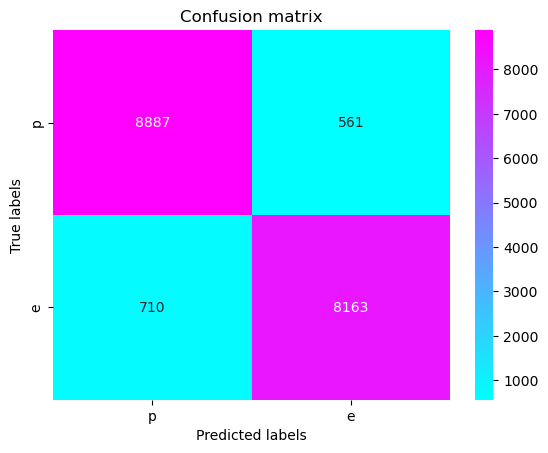

The test accuracy of random forest = 93.06260575296108%

               precision    recall  f1-score   support

           0       0.93      0.94      0.93      9448
           1       0.94      0.92      0.93      8873

    accuracy                           0.93     18321
   macro avg       0.93      0.93      0.93     18321
weighted avg       0.93      0.93      0.93     18321

[[8887  561]
 [ 710 8163]]
The F1-score of SVM= 93.06037268675416%


In [34]:
# Performing SVM on the final dataframes:
svm = SVC(kernel='rbf', C=1, gamma=3,random_state=42)
scores_svm = cross_val_score(svm, X_train_v, y_train, cv=k)
svm.fit(X_train_v, y_train)
val_accuracy_svm = svm.score(X_val, y_val)
train_accuracy_svm = svm.score(X_train_v, y_train)
print(f"The validation accuracy of support vector machine =  {val_accuracy_svm * 100}%")
print(f"The training accuracy of support vector machine = {train_accuracy_svm * 100}%")

predicted_labels_svm = svm.predict(X_val)


conf_mat = confusion_matrix(y_val, predicted_labels_svm)

print(conf_mat)

predicted_labels_svm = svm.predict(X_test)
print(f"The test accuracy of support vector machine = {accuracy_score(predicted_labels_svm, y_test) * 100}%")
print('\n', classification_report(y_test, predicted_labels_svm))
conf_mat = confusion_matrix(y_test, predicted_labels_svm)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='cool', xticklabels=['p', 'e'], yticklabels=['p', 'e'])
plt.title("Confusion matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()


predicted_labels_svmnew = svm.predict(X_test)
print(f"The test accuracy of random forest = {accuracy_score(predicted_labels_svmnew, y_test) * 100}%")
print('\n', classification_report(y_test, predicted_labels_svmnew))
# Calculate confusion matrix for the validation set:
conf_mat = confusion_matrix(y_test, predicted_labels_svmnew)
print(conf_mat)

f1score_svmnew = f1_score(y_test, predicted_labels_svmnew, average='weighted')
print(f"The F1-score of SVM= {f1score_svmnew * 100}%")

**Naive Bayes on PCA data**

In [35]:
bayes = GaussianNB()
scores_bayes = cross_val_score(bayes, X_train_v, y_train, cv = k)
bayes.fit(X_train_v, y_train)
val_accuracy_bayes = bayes.score(X_val, y_val)
train_accuracy_bayes = bayes.score(X_train_v, y_train)
print(f"The validation accuracy of naive bayes classifier = {val_accuracy_bayes * 100}%")
print(f"The training accuracy of naive bayes classifier = {train_accuracy_bayes * 100}%")
predicted_labels_bayes = bayes.predict(X_val)

conf_mat = confusion_matrix(y_val, predicted_labels_bayes)

print(conf_mat)


predicted_labels_bayesnew = bayes.predict(X_test)
print(f"The test accuracy of random forest = {accuracy_score(predicted_labels_bayesnew, y_test) * 100}%")
print('\n', classification_report(y_test, predicted_labels_bayesnew))

conf_mat = confusion_matrix(y_test, predicted_labels_bayesnew)
print(conf_mat)

f1score_bayesnew = f1_score(y_test, predicted_labels_bayesnew, average='weighted')
print(f"The F1-score of random forest = {f1score_bayesnew * 100}%")

The validation accuracy of naive bayes classifier = 62.69005847953216%
The training accuracy of naive bayes classifier = 63.98034972805428%
[[2126 2370]
 [ 820 3234]]
The test accuracy of random forest = 64.07947164456088%

               precision    recall  f1-score   support

           0       0.73      0.48      0.58      9448
           1       0.59      0.81      0.69      8873

    accuracy                           0.64     18321
   macro avg       0.66      0.65      0.63     18321
weighted avg       0.67      0.64      0.63     18321

[[4527 4921]
 [1660 7213]]
The F1-score of random forest = 63.12153320170004%


**MLP on PCA data**

C:\Users\Kranti\AppData\Local\Temp\ipykernel_33924\3868489163.py:6: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_estimator = KerasClassifier(build_fn = model_mlp, epochs = 5, batch_size = 32, verbose = 0)


Training accuracy of the MLP = 86.55477166175842%
Validation accuracy of the MLP = 86.23896479606628%


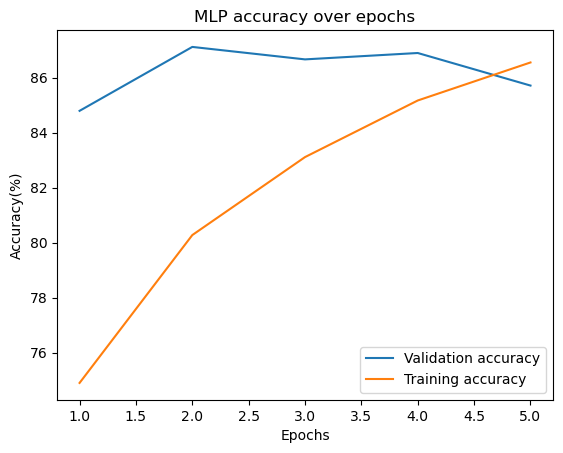

268/268 [==============================] - 0s 948us/step
[[3883  613]
 [ 485 3569]]
573/573 [==============================] - 1s 991us/step
The test accuracy of random forest = 86.80203045685279%

               precision    recall  f1-score   support

           0       0.88      0.86      0.87      9448
           1       0.86      0.87      0.87      8873

    accuracy                           0.87     18321
   macro avg       0.87      0.87      0.87     18321
weighted avg       0.87      0.87      0.87     18321

[[8146 1302]
 [1116 7757]]
The F1-score of random forest = 86.80487666822559%


In [36]:
def model_mlp():
  mlp = keras.models.Sequential([keras.layers.Dense(64, activation = 'relu', input_shape = (X_train.shape[1],)), keras.layers.Dense(32, activation = 'relu'), keras.layers.Dense(1, activation = 'sigmoid')])
  mlp.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
  return mlp

keras_estimator = KerasClassifier(build_fn = model_mlp, epochs = 5, batch_size = 32, verbose = 0)
cv_scores = cross_val_score(keras_estimator, X_train_v, y_train, cv = k)
model_train = model_mlp()
hist = model_train.fit(X_train_v, y_train, epochs = 5, batch_size = 32, verbose = 0)
training_acc = hist.history['accuracy']
print(f"Training accuracy of the MLP = {training_acc[-1] * 100}%")
print(f"Validation accuracy of the MLP = {cv_scores.mean() * 100}%")

plt.plot(range(1, 6), cv_scores * 100, label = "Validation accuracy")
plt.plot(range(1, 6), np.array(training_acc) * 100, label = "Training accuracy")
plt.title("MLP accuracy over epochs")
plt.ylabel('Accuracy(%)')
plt.xlabel('Epochs')
plt.legend()
plt.show()

predicted_scores_mlp = model_train.predict(X_val)
predicted_labels_mlp = np.round(predicted_scores_mlp)

conf_mat = confusion_matrix(y_val, predicted_labels_mlp)
print(conf_mat)

predicted_labels_mlpnew = model_train.predict(X_test)
predicted_labels_mlpnew = np.round(predicted_labels_mlpnew)
print(f"The test accuracy of random forest = {accuracy_score(predicted_labels_mlpnew, y_test) * 100}%")
print('\n', classification_report(y_test, predicted_labels_mlpnew))

conf_mat = confusion_matrix(y_test, predicted_labels_mlpnew)
print(conf_mat)

f1score_mlpnew = f1_score(y_test, predicted_labels_mlpnew, average='weighted')
print(f"The F1-score of random forest = {f1score_mlpnew * 100}%")

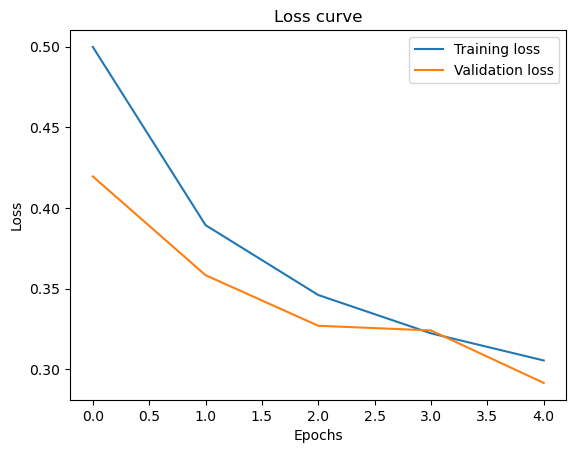

In [37]:
model = model_mlp()
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', mode = 'min')
hist_loss = model.fit(X_train_v, y_train, epochs = 5, batch_size = 32, verbose = 0, validation_data=(X_val, y_val), callbacks = [checkpoint])
model.load_weights('best_weights.h5')
losses = model.history.history['loss']

plt.plot(hist_loss.history['loss'], label = 'Training loss')
plt.plot(hist_loss.history['val_loss'], label = 'Validation loss')
plt.title("Loss curve")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# **Univariate Feature Selection**

In [38]:
del concatenated_df_test['label']
del concatenated_df_train['label']
ufs = SelectKBest(score_func = chi2, k = 7)
ufs.fit(abs(concatenated_df_train), label_column_train)
X_train_selected = ufs.transform(concatenated_df_train)
X_test_selected = ufs.transform(concatenated_df_test)
X_train_v, X_val, y_train, y_val = train_test_split(X_train_selected, label_column_train, test_size = 0.2, random_state = 42) # Splitting the training dataset into validation set (80/20).
k = 5
kf = KFold(n_splits = k, shuffle = True, random_state = 42)

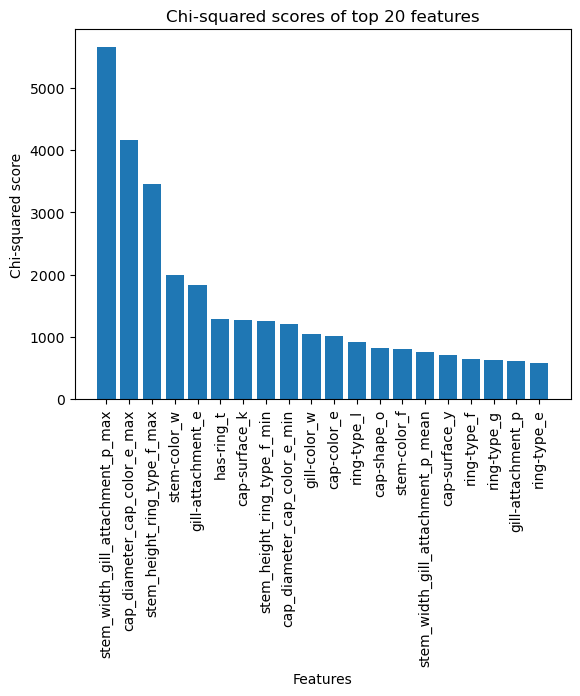

In [39]:
ufs = SelectKBest(score_func = chi2, k = 20)
ufs.fit(abs(concatenated_df_train), label_column_train)
chi_scores = ufs.scores_
feature_names = concatenated_df_train.columns
sorted_idx = np.argsort(chi_scores)[::-1][:20]

plt.figure()
plt.bar(range(20), chi_scores[sorted_idx])
plt.xticks(range(20), feature_names[sorted_idx], rotation=90)
plt.xlabel('Features')
plt.ylabel('Chi-squared score')
plt.title("Chi-squared scores of top 20 features")
plt.show()

**Logistic Regression on UFS data**

Current fold- 1
The validation accuracy of logistic regression = 71.39181286549707%
The training accuracy of logistic regression = 72.59196444236505%
+++++++++++++++++++++++++
Current fold- 2
The validation accuracy of logistic regression = 72.99415204678363%
The training accuracy of logistic regression = 72.19135621966197%
+++++++++++++++++++++++++
Current fold- 3
The validation accuracy of logistic regression = 73.46198830409357%
The training accuracy of logistic regression = 73.06567635534242%
+++++++++++++++++++++++++
Current fold- 4
The validation accuracy of logistic regression = 72.67516668616213%
The training accuracy of logistic regression = 72.27111903856837%
+++++++++++++++++++++++++
Current fold- 5
The validation accuracy of logistic regression = 71.98502748859515%
The training accuracy of logistic regression = 72.44363870288605%
+++++++++++++++++++++++++


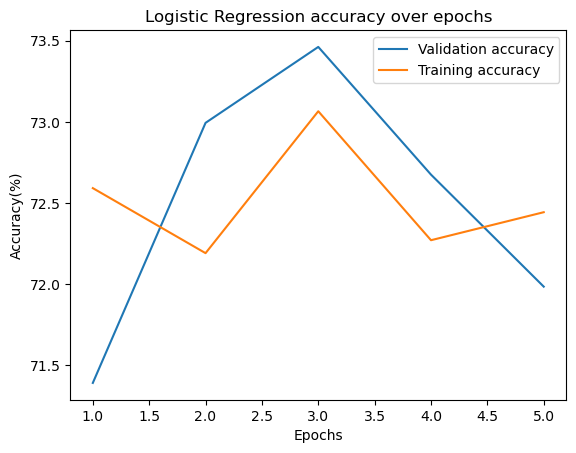

The test accuracy of random forest classifier = 70.34004694066918%

               precision    recall  f1-score   support

           0       0.77      0.61      0.68      9448
           1       0.66      0.80      0.72      8873

    accuracy                           0.70     18321
   macro avg       0.71      0.71      0.70     18321
weighted avg       0.71      0.70      0.70     18321

[[5773 3675]
 [1759 7114]]
The F1-score of Logistic Regression = 70.11178717647073%


In [40]:
val_acc_list = []
train_acc_list = []

for fold, (train_index, val_index) in enumerate(kf.split(X_train_selected)):
    print(f"Current fold- {fold + 1}")
    X_train_v, X_val = X_train_selected[train_index], X_train_selected[val_index]
    y_train, y_val = label_column_train[train_index], label_column_train[val_index]
    lr = LogisticRegression()
    lr.fit(X_train_v, y_train)
    val_accuracy = lr.score(X_val, y_val)
    train_accuracy = lr.score(X_train_v, y_train)
    val_acc_list.append(val_accuracy)
    train_acc_list.append(train_accuracy)
    print(f"The validation accuracy of logistic regression = {val_accuracy * 100}%")
    print(f"The training accuracy of logistic regression = {train_accuracy * 100}%")
    print('+' * 25)

epochs = np.arange(1, k + 1)
plt.plot(epochs, np.array(val_acc_list) * 100, label = "Validation accuracy")
plt.plot(epochs, np.array(train_acc_list) * 100, label = "Training accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.title("Logistic Regression accuracy over epochs")
plt.legend()
plt.show()

predicted_labels_logreg_ufs = lr.predict(X_test_selected)
accuracy_logreg_ufs = accuracy_score(predicted_labels_logreg_ufs, last_column_test)
print(f"The test accuracy of random forest classifier = {accuracy_logreg_ufs * 100}%")
print('\n', classification_report(last_column_test, predicted_labels_logreg_ufs))

conf_mat = confusion_matrix(last_column_test, predicted_labels_logreg_ufs)
print(conf_mat)

f1score_lognew = f1_score(y_test, predicted_labels_logreg_ufs, average='weighted')
print(f"The F1-score of Logistic Regression = {f1score_lognew * 100}%")

**Support Vector Machine on UFS data**

The training accuracy of support vector machine = 73.95433710122595%
The validation accuracy of support vector machine = 73.95433794452208%


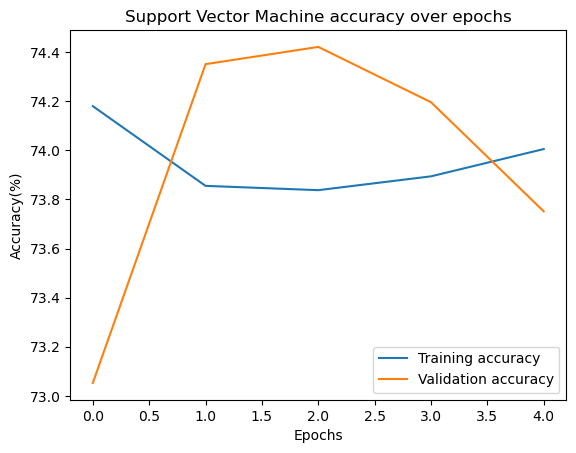

In [ ]:
svm_ufs = SVC(kernel = 'rbf', C = 1, gamma = 3)
train_accs = []
val_accs = []

for train_index, val_index in kf.split(X_train_selected):
    X_train, X_val = X_train_selected[train_index], X_train_selected[val_index]
    y_train, y_val = label_column_train[train_index], label_column_train[val_index]
    svm_ufs.fit(X_train, y_train)
    train_accuracy_svm = svm_ufs.score(X_train, y_train)
    train_accs.append(train_accuracy_svm)
    val_accuracy_ufs = svm_ufs.score(X_val, y_val)
    val_accs.append(val_accuracy_ufs)
    
print(f"The training accuracy of support vector machine = {np.mean(train_accs) * 100}%")
print(f"The validation accuracy of support vector machine = {np.mean(val_accs) * 100}%")

plt.plot(np.array(train_accs) * 100, label = "Training accuracy")
plt.plot(np.array(val_accs) * 100, label = "Validation accuracy")
plt.title("Support Vector Machine accuracy over epochs")
plt.xlabel('Epochs')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.show()

predicted_labels_svm_ufs = svm_ufs.predict(X_test_selected)
accuracy_svm_ufs = accuracy_score(predicted_labels_svm_ufs, last_column_test)
print(f"The test accuracy of support vector machine = {accuracy_svm_ufs * 100}%")
print('\n', classification_report(last_column_test, predicted_labels_svm_ufs))

# Calculate confusion matrix for the validation set
conf_mat = confusion_matrix(last_column_test, predicted_labels_svm_ufs)
# Print the confusion matrix
print(conf_mat)


f1score_svmnew = f1_score(y_test, predicted_labels_svm_ufs, average='weighted')
print(f"The F1-score of SVM = {f1score_svmnew * 100}%")

**Naive Bayes on UFS data**

In [ ]:
train_accs = []
val_accs_nb = []

for train_index, val_index in kf.split(X_train_selected):
    X_train_fold, X_val_fold = X_train_selected[train_index], X_train_selected[val_index]
    y_train_fold, y_val_fold = label_column_train[train_index], label_column_train[val_index]
    bayes_ufs = GaussianNB()
    bayes_ufs.fit(X_train_fold, y_train_fold)
    train_acc = bayes_ufs.score(X_train_fold, y_train_fold) 
    val_acc = bayes_ufs.score(X_val_fold, y_val_fold)
    train_accs.append(train_acc)
    val_accs_nb.append(val_acc)
    
print(f"Training accuracy = {np.mean(train_accs) * 100}% | Validation accuracy: {np.mean(val_accs_nb) * 100}%")

plt.plot(np.array(train_accs) * 100, label = "Training accuracy")
plt.plot(np.array(val_accs_nb) * 100, label = "Validation accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Gaussian Naive Bayes Classifier accuracy over epochs")
plt.legend()
plt.show()

predicted_labels_bayes_ufs = bayes_ufs.predict(X_test_selected)
accuracy_bayes_ufs = accuracy_score(predicted_labels_bayes_ufs, last_column_test)
print(f"The test accuracy of Gaussian Naive Bayes classifier = {accuracy_bayes_ufs * 100}%")
print('\n', classification_report(last_column_test, predicted_labels_bayes_ufs))

# Calculate confusion matrix for the validation set
conf_mat = confusion_matrix(last_column_test, predicted_labels_bayes_ufs)
# Print the confusion matrix
print(conf_mat)

f1score_bayes_ufs = f1_score(y_test, predicted_labels_bayes_ufs, average='weighted')
print(f"The F1-score of Gaussian Naive Bayes = {f1score_bayes_ufs * 100}%")

**Random Forest Classifier on UFS data**

In [ ]:
rf_ufs = RandomForestClassifier()
scores_rf_ufs = []
train_acc_rf_ufs = []
val_acc_rf_ufs = []

for i in range(k):
    X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(X_train_v, y_train, test_size = 0.2, random_state = i)
    rf_ufs.fit(X_train_fold, y_train_fold)
    train_acc_rf_ufs.append(rf_ufs.score(X_train_fold, y_train_fold))
    val_acc_rf_ufs.append(rf_ufs.score(X_val_fold, y_val_fold))
    scores_rf_ufs.append(rf_ufs.score(X_val_fold, y_val_fold))

print(f"The training accuracy of Random Forest Classifier = {train_acc_rf_ufs[-1] * 100}%")
print(f"The validation accuracy of Random Forest Classifier = {val_acc_rf_ufs[-1] * 100}%")

plt.plot(range(1, k + 1), np.array(train_acc_rf_ufs) * 100, label = "Training accuracy")
plt.plot(range(1, k + 1), np.array(val_acc_rf_ufs) * 100, label = "Validation accuracy")
plt.title("Random Forest Classifier accuracy over epochs")
plt.xlabel('Folds')
plt.ylabel('Accuracy')
plt.xticks(range(1, k + 1))
plt.legend()
plt.show()


**MLP on UFS data**

In [ ]:
def model_mlp_ufs():
    mlp_ufs = keras.models.Sequential([
        keras.layers.Dense(64, activation='relu', input_shape=(X_train_selected.shape[1],)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    mlp_ufs.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return mlp_ufs

keras_estimator = KerasClassifier(build_fn=model_mlp_ufs, epochs=5, batch_size=32, verbose=0)
cv_scores = cross_val_score(keras_estimator, X_train_v, y_train, cv=k)
model_train_ufs = model_mlp_ufs()
hist_ufs = model_train_ufs.fit(X_train_v, y_train, epochs=5, batch_size=32, verbose=0)
training_acc = hist_ufs.history['accuracy']
print(f"Training accuracy of the MLP = {training_acc[-1] * 100}%")
print(f"Validation accuracy of the MLP = {cv_scores.mean() * 100}%")

plt.plot(range(1, 6), cv_scores * 100, label="Validation accuracy")
plt.plot(range(1, 6), np.array(training_acc) * 100, label="Training accuracy")
plt.title("MLP accuracy over epochs")
plt.ylabel('Accuracy(%)')
plt.xlabel('Epochs')
plt.legend()
plt.show()

predicted_labels_mlp_ufs = model_train_ufs.predict(X_test_selected)
predicted_labels_mlp_ufs = (predicted_labels_mlp_ufs > 0.5).astype(int)
accuracy_mlp_ufs = accuracy_score(predicted_labels_mlp_ufs, last_column_test)
print(f"The test accuracy of MLP = {accuracy_mlp_ufs}")
print('\n', classification_report(last_column_test, predicted_labels_mlp_ufs))

conf_mat = confusion_matrix(last_column_test, predicted_labels_mlp_ufs)
print(conf_mat)

In [ ]:
model = model_mlp_ufs()
checkpoint = ModelCheckpoint('best_weights.h5', save_best_only = True, save_weights_only = True, monitor = 'val_loss', mode = 'min')
hist_loss = model.fit(X_train_v, y_train, epochs = 5, batch_size = 32, verbose = 0, validation_data=(X_val, y_val), callbacks = [checkpoint])
model.load_weights('best_weights.h5')
losses = model.history.history['loss']

plt.plot(hist_loss.history['loss'], label = 'Training loss')
plt.plot(hist_loss.history['val_loss'], label = 'Validation loss')
plt.title("Loss curve")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(np.array(val_acc_list) * 100, label = "Logistic Regression")
plt.plot(np.array(val_acc_rf_ufs) * 100, label = "Random Forest Classifier")
plt.plot(np.array(val_accs) * 100, label = "Support Vector Machine")
plt.plot(np.array(val_accs_nb) * 100, label = "Naive Bayes Classifier")
plt.plot(np.array(cv_scores) * 100, label = "MLP")
plt.title("Models' performances")
plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show() 

From the above graph it is evident that Random Forest Classifier is the best model.

In [ ]:
predicted_labels_rf_ufs = rf_ufs.predict(X_test_selected)
binary_predicted_labels_rf_ufs = np.where(predicted_labels_rf_ufs > 0.5, 1, 0)
accuracy_rf_ufs = accuracy_score(binary_predicted_labels_rf_ufs, last_column_test)
print(f"The test accuracy of random forest classifier = {accuracy_rf_ufs * 100}%")
print('\n', classification_report(last_column_test, binary_predicted_labels_rf_ufs))
conf_mat_ufs = confusion_matrix(last_column_test, binary_predicted_labels_rf_ufs)
sns.heatmap(conf_mat_ufs, annot = True, fmt = 'd', cmap = 'cool', xticklabels = ['p', 'e'], yticklabels = ['p', 'e'])
plt.title("Confusion matrix")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.show()

conf_mat = confusion_matrix(last_column_test, binary_predicted_labels_rf_ufs)
print(conf_mat)

f1score_rfnew = f1_score(last_column_test, binary_predicted_labels_rf_ufs, average='weighted')
print(f"The F1-score of random forest = {f1score_rfnew * 100}%")